<a href="https://colab.research.google.com/github/P0W/nse_indices/blob/main/NSE200_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Save this script as setup_ta_lib.py in Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy TA-Lib files
!cp -r /content/drive/MyDrive/ta-lib/libta* /usr/lib/
!cp -r /content/drive/MyDrive/ta-lib/ta* /usr/include/

# Install Python dependencies
!pip install TA-Lib
!pip install seaborn
!pip install tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import yfinance as yf
import pandas as pd
import requests
import os
import numpy as np
import talib
import tqdm

In [19]:
def format_file(prefix, ext):
  curr_date =  pd.Timestamp.now().strftime('%Y-%m-%d')
  return f"{prefix}_{curr_date}.{ext}"

In [20]:
# prompt: nse-200 list of stocks as csv if not downloaded already
def download_nifty_list():
  nse_fname = format_file('nse-200', 'csv')
  if not os.path.exists(nse_fname):
    url = 'https://archives.nseindia.com/content/indices/ind_nifty200list.csv'
    response = requests.get(url)
    with open(nse_fname, 'wb') as f:
        f.write(response.content)
    print('Nifty list downloaded successfully.')
  else:
    print('Nifty list already downloaded.')
  ## return a list of stocks with .NS prefix
  df = pd.read_csv(nse_fname)
  stocks = df['Symbol'].tolist()
  return stocks

In [21]:
## for each stock store the hourly adjusted close and volume for last 1 week from yfinance
def get_momentum(symbol):
    file_path = format_file(symbol, 'csv')
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, index_col=0)
        data.index = pd.to_datetime(data.index)
    else:
        stock = yf.Ticker(f'{symbol}.NS')
        data = stock.history(period='5d', interval='1h', auto_adjust=True)
        data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
        data.index = data.index.strftime('%Y-%m-%d %H:%M:%S')
        data.to_csv(file_path)

    # Convert to NumPy arrays of type double for TA-Lib
    close_prices = np.array(data['Close'], dtype=np.double)
    high_prices = np.array(data['High'], dtype=np.double)
    low_prices = np.array(data['Low'], dtype=np.double)
    volumes = np.array(data['Volume'], dtype=np.double)

   # Calculate TA-Lib momentum indicators
    data['RSI'] = talib.RSI(close_prices, timeperiod=5)
    data['MFI'] = talib.MFI(high_prices, low_prices, close_prices, volumes, timeperiod=5)
    data['MOM'] = talib.MOM(close_prices, timeperiod=5)
    data['CMO'] = talib.CMO(close_prices, timeperiod=5)
    data['AROONOSC'] = talib.AROONOSC(high_prices, low_prices, timeperiod=5)
    data['WILLR'] = talib.WILLR(high_prices, low_prices, close_prices, timeperiod=5)

    # Normalize indicator values
    data['RSI'] = (data['RSI'] - 50) / 50
    data['MFI'] = (data['MFI'] - 50) / 50
    data['MOM'] = data['MOM'] / np.max(np.abs(data['MOM']))
    data['CMO'] = data['CMO'] / 100
    data['AROONOSC'] = data['AROONOSC'] / 100
    data['WILLR'] = data['WILLR'] / 100

    # Assign weights to indicators
    weights = {
        'MFI': 0.3,
        'RSI': 0.15,
        'MOM': 0.15,
        'CMO': 0.15,
        'AROONOSC': 0.15,
        #'STOCH_AVG': 0.1,
        #'MACD': 0.1,
        'WILLR': 0.1
    }

    data['Momentum_Score'] = (
        weights['RSI'] * data['RSI'] +
        weights['MFI'] * data['MFI'] +
        weights['MOM'] * data['MOM'] +
        weights['CMO'] * data['CMO'] +
        weights['AROONOSC'] * data['AROONOSC'] +
        weights['WILLR'] * data['WILLR']
    )

    data = data.to_dict(orient='index')

    for date in data:
        data[date]['Momentum_Score'] = round(data[date]['Momentum_Score']*100, 2)

    return data

In [22]:
def get_scores_data_frame():
    stocks = download_nifty_list()
    data = []
    for stock in tqdm.tqdm(stocks):
        try:
            momentum_data = get_momentum(stock)
            for date in momentum_data:
                data.append([stock, date, momentum_data[date]['Momentum_Score']])
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")


    df = pd.DataFrame(data, columns=['Symbol', 'Date', 'Momentum_Score'])
    return df

In [23]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth import default

def dump_to_sheet(pivot_table):
  # Authenticate with Google
  auth.authenticate_user()
  creds, _ = default()
  gc = gspread.authorize(creds)

  # Open the Google Sheet (or create it if it doesn't exist)
  spreadsheet_name = 'NSE-200'
  try:
      sh = gc.open(spreadsheet_name)
  except gspread.exceptions.SpreadsheetNotFound:
      sh = gc.create(spreadsheet_name)

  # Select the worksheet (or create it if it doesn't exist)
  worksheet_name = 'Momentum Scores'
  try:
      worksheet = sh.worksheet(worksheet_name)
  except gspread.exceptions.WorksheetNotFound:
      worksheet = sh.add_worksheet(title=worksheet_name, rows="100", cols="20")


  # Convert pivot_table to a list of lists for writing to Google Sheet
  data = pivot_table.reset_index().values.tolist()

  # Write the data to the Google Sheet
  worksheet.update(data, 'A1')

Nifty list downloaded successfully.


  8%|▊         | 17/200 [00:02<00:26,  7.01it/s]<ipython-input-21-b61a263b21cf>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RSI'] = talib.RSI(close_prices, timeperiod=5)
100%|██████████| 200/200 [00:26<00:00,  7.55it/s]


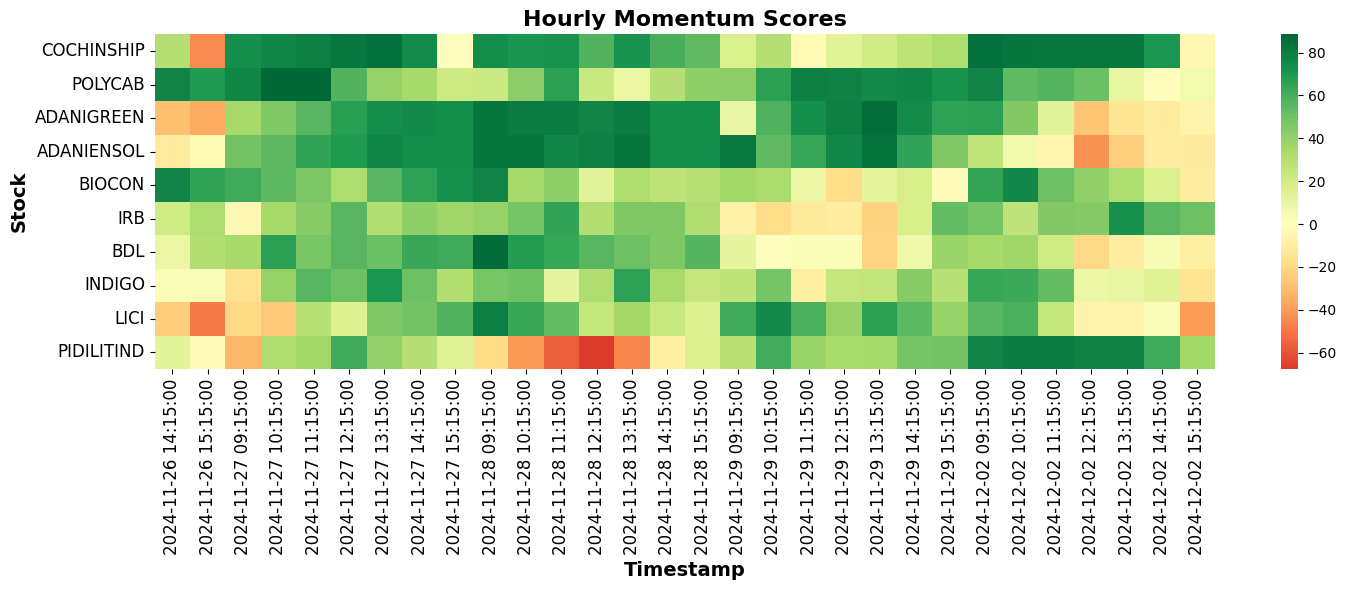

In [24]:
## Draw a heatmap for above using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

def main():
  df = get_scores_data_frame()

  pivot_table = df.pivot_table(index='Symbol', columns='Date', values='Momentum_Score', aggfunc='mean')

  # Calculate average momentum score for each stock
  pivot_table['Average_Score'] = pivot_table.mean(axis=1)

  # Sort rows based on weighted average momentum score
  pivot_table = pivot_table.sort_values(by='Average_Score', ascending=False)



  # Remove the 'Average_Score' column before plotting
  pivot_table = pivot_table.drop('Average_Score', axis=1)


  # Sort the columns (dates) in increasing order
  pivot_table = pivot_table.sort_index(axis=1)

  dump_to_sheet(pivot_table)

  ## Take the top stocks only
  pivot_table = pivot_table.head(10)

  plt.figure(figsize=(15, 6))
  sns.heatmap(pivot_table, cmap='RdYlGn', center=0, annot=False)
  plt.title('Hourly Momentum Scores', fontsize=16, fontweight='bold')
  plt.xlabel('Timestamp', fontsize=14, fontweight='bold')
  plt.ylabel('Stock', fontsize=14, fontweight='bold')
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

if __name__ == "__main__":
    main()